In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Paths to the main dataset and the splits
train_dir = 'E:/Music Chord/Data70_30_ (75)/Train'
validation_dir = 'E:/Music Chord/Data70_30_ (75)/Validation'


In [3]:
# Image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),  # Adjusted input size
    batch_size=32,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),  # Adjusted input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 624 images belonging to 12 classes.
Found 276 images belonging to 12 classes.


In [15]:
# Load the InceptionV3 model with pre-trained weights, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [16]:
# Freeze the base model's layers
for layer in base_model.layers[:-50]:  # Unfreeze the last 50 layers
    layer.trainable = False

In [21]:
# Create a new model with additional layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(12, activation='softmax')
])

In [22]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Define callbacks
checkpoint = ModelCheckpoint('best_modelI.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

In [38]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    validation_steps=validation_set.samples // validation_set.batch_size,
    validation_data=validation_set,
    epochs=15,
)

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6035 - loss: 1.8099 - val_accuracy: 0.6055 - val_loss: 1.7866
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5000 - loss: 1.9905 - val_accuracy: 1.0000 - val_loss: 0.8469
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5643 - loss: 2.0287 - val_accuracy: 0.5977 - val_loss: 1.8641
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5312 - loss: 2.0538 - val_accuracy: 1.0000 - val_loss: 0.8628
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5420 - loss: 2.0056 - val_accuracy: 0.5898 - val_loss: 1.8734
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5312 - loss: 2.0947 - val_accuracy: 1.0000 - val_loss: 0.8302
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5107 - loss: 2.0781 - val_accuracy: 0.5977 - val_loss: 1.8219
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5625 - loss: 1.9426 - val_accuracy: 1.0000 - val_l

In [39]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_set)
print('Test Loss:', test_loss)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6453 - loss: 1.7531
Test Loss: 1.7215766906738281
Test Accuracy: 65.58%


In [40]:
# Save the trained model
model.save('E:/Music Chord/Models/inceptionV3_Upd.h5')
print("model saved")

model saved


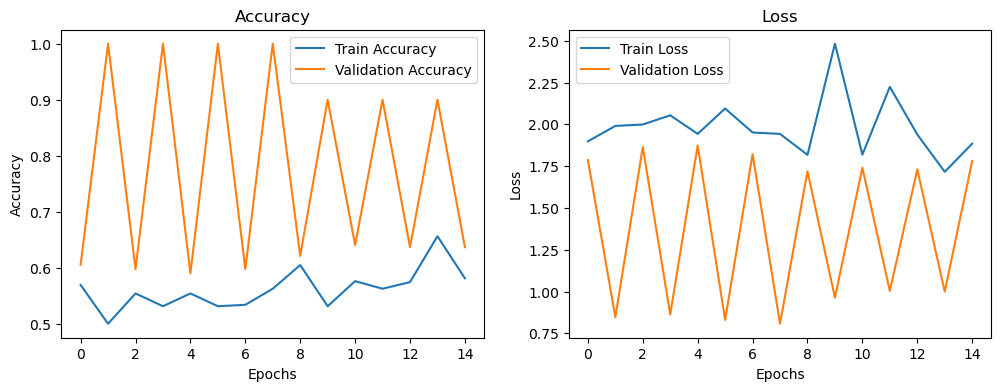

In [41]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


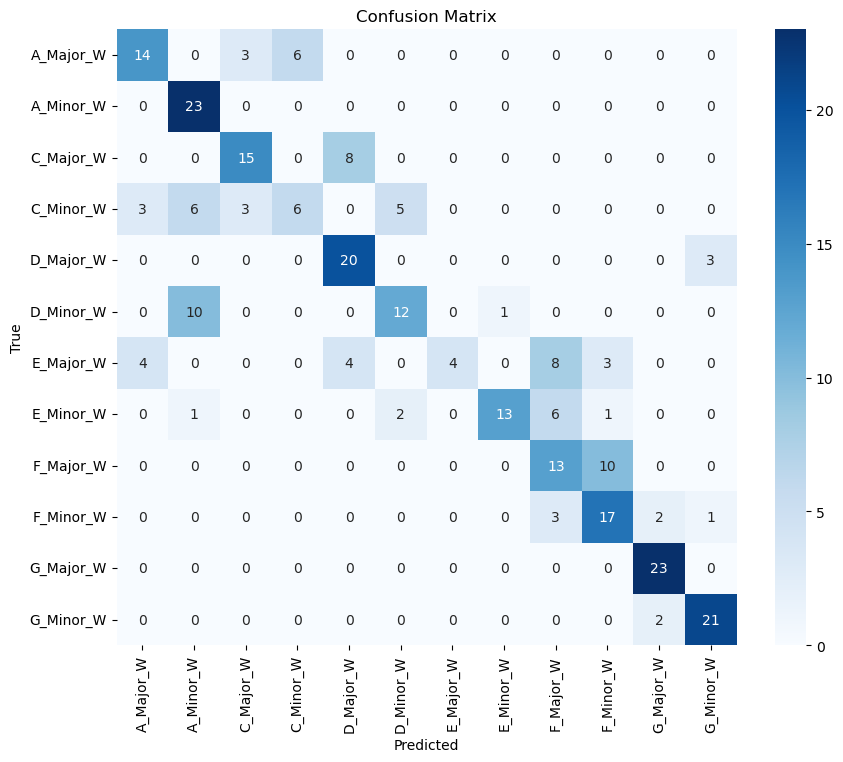

              precision    recall  f1-score   support

   A_Major_W       0.67      0.61      0.64        23
   A_Minor_W       0.57      1.00      0.73        23
   C_Major_W       0.71      0.65      0.68        23
   C_Minor_W       0.50      0.26      0.34        23
   D_Major_W       0.62      0.87      0.73        23
   D_Minor_W       0.63      0.52      0.57        23
   E_Major_W       1.00      0.17      0.30        23
   E_Minor_W       0.93      0.57      0.70        23
   F_Major_W       0.43      0.57      0.49        23
   F_Minor_W       0.55      0.74      0.63        23
   G_Major_W       0.85      1.00      0.92        23
   G_Minor_W       0.84      0.91      0.87        23

    accuracy                           0.66       276
   macro avg       0.69      0.66      0.63       276
weighted avg       0.69      0.66      0.63       276



In [42]:
# Predictions and Confusion Matrix
validation_steps = validation_set.samples // validation_set.batch_size
Y_pred = model.predict(validation_set, validation_steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_set.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(validation_set.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Single image Without CN ,ACC

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


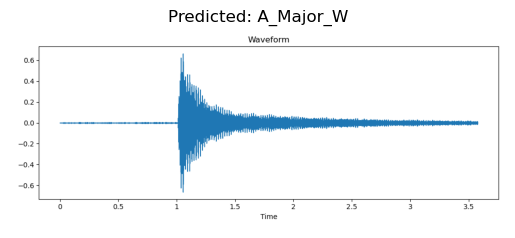

In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the image
    return img_array

# Function to classify and display the image
def classify_and_display_image(image_path, model, class_indices):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[predicted_class]

    plt.imshow(load_img(image_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Load the saved model
model = load_model('E:/Music Chord/Models/inceptionV3_Upd.h5')

# Example usage
image_path = 'E:/Music Chord/Data70_30_ (75)/Test/A_major_(53).png'  # Change this to the path of the image you want to classify
classify_and_display_image(image_path, model, validation_set.class_indices)

Multiple image without CM ,ACC

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


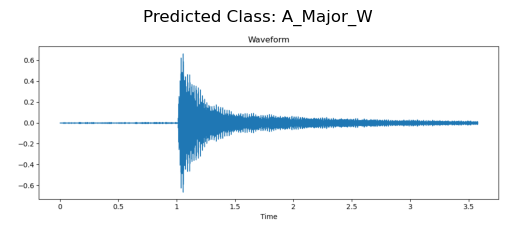

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


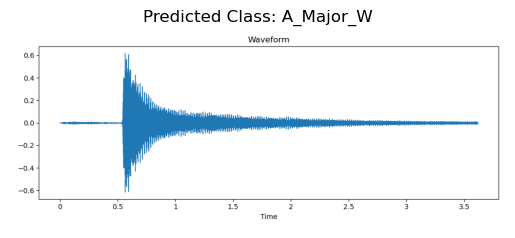

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


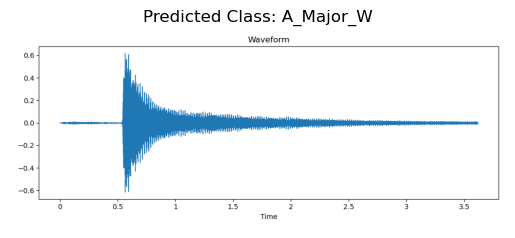

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


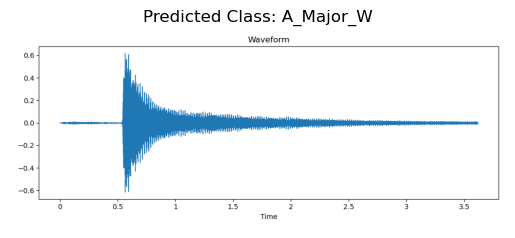

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


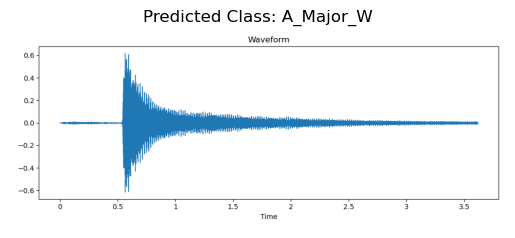

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


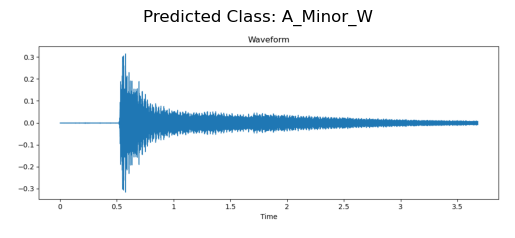

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


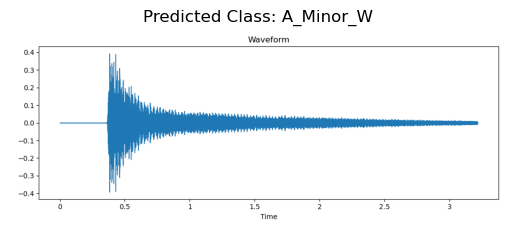

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


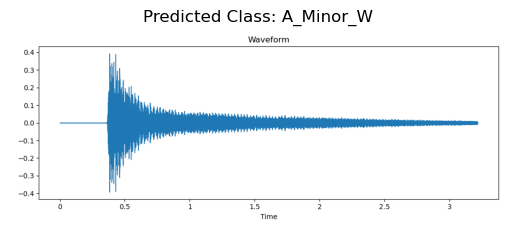

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


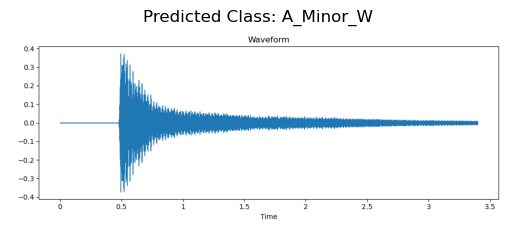

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


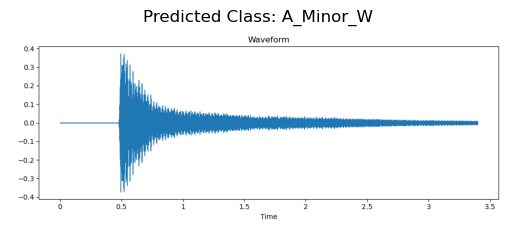

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


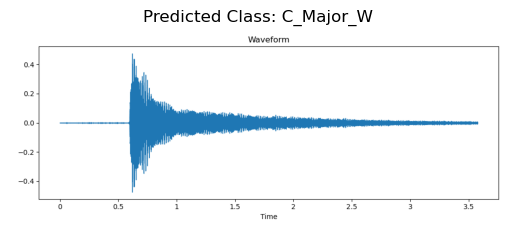

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


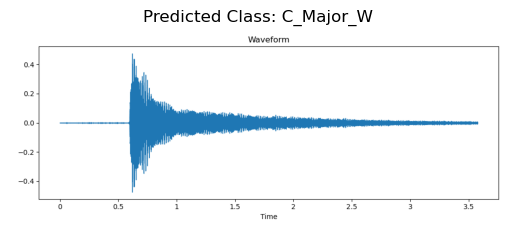

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


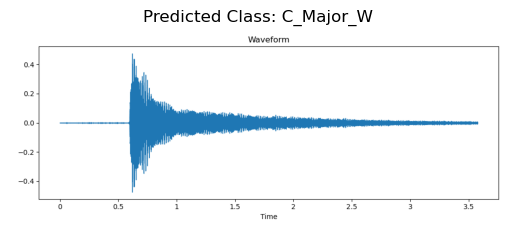

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


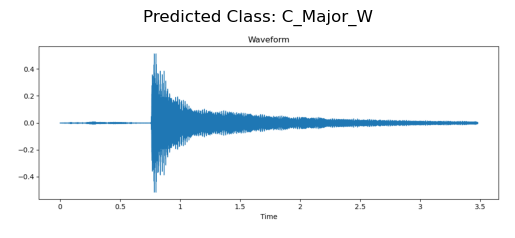

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


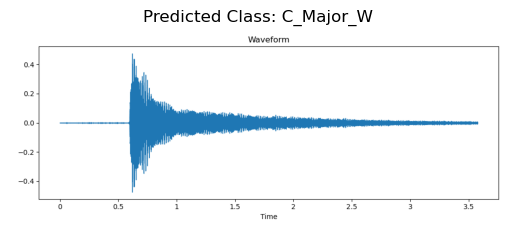

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


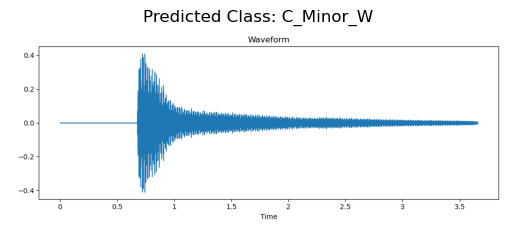

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


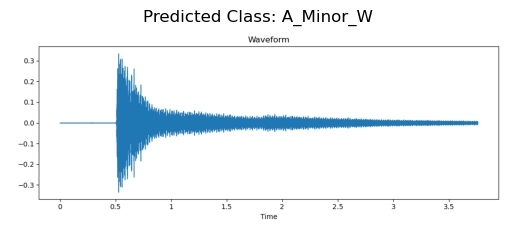

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


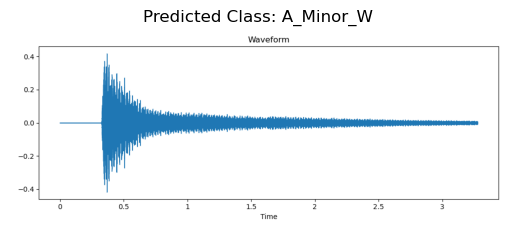

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


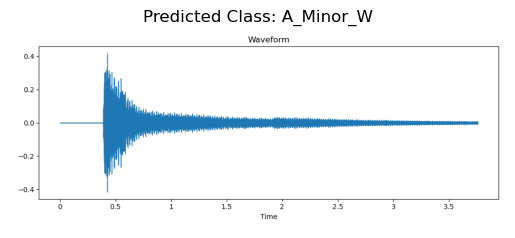

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


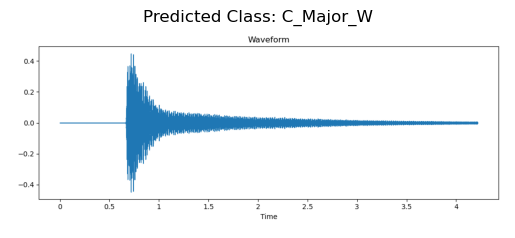

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


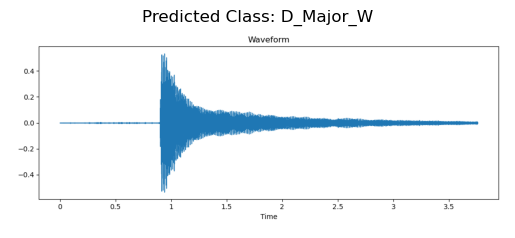

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


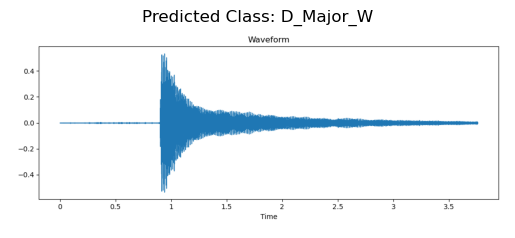

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


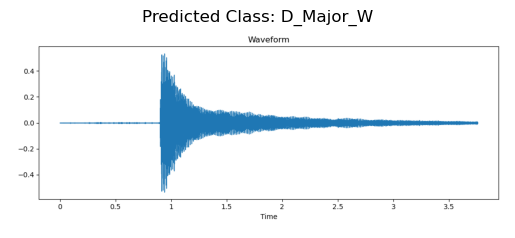

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


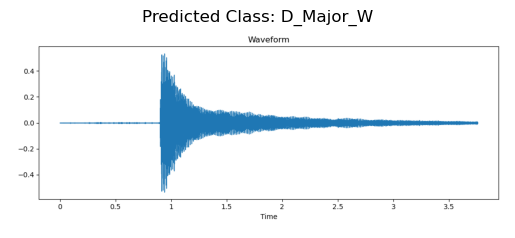

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


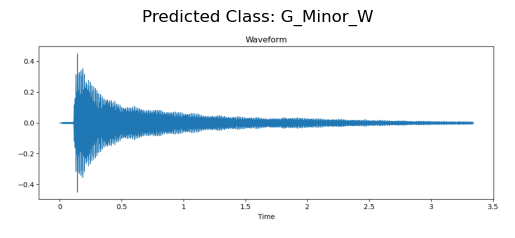

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


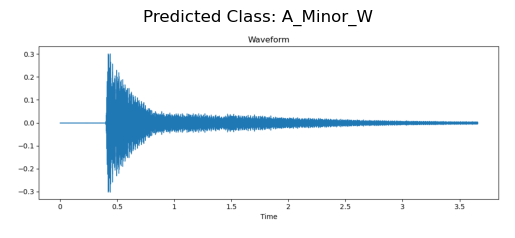

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


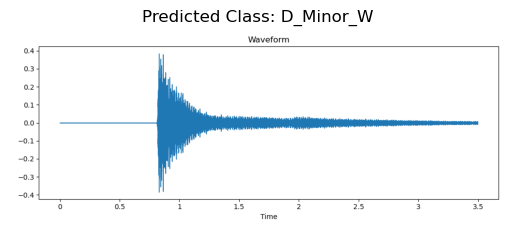

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


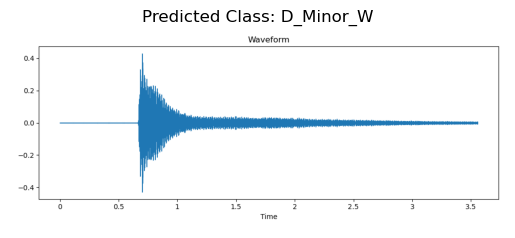

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


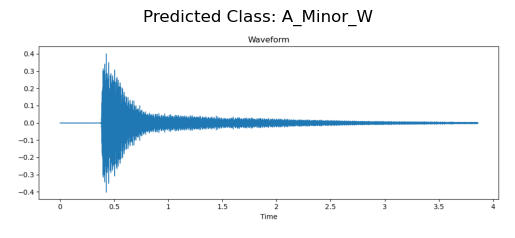

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


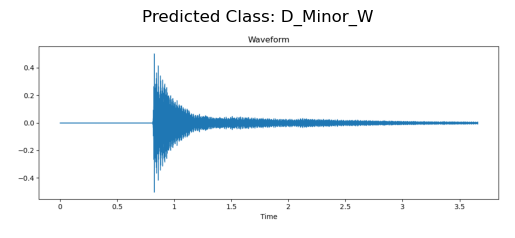

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


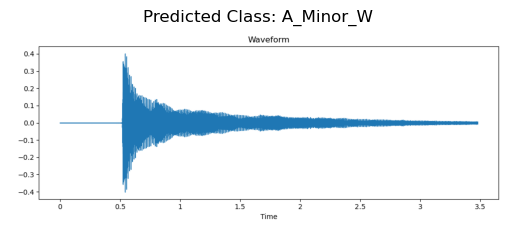

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


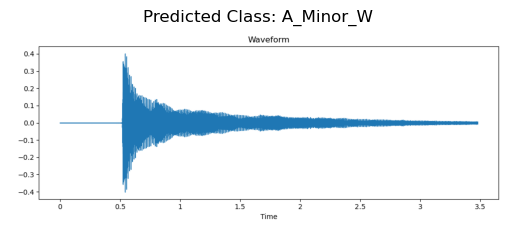

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


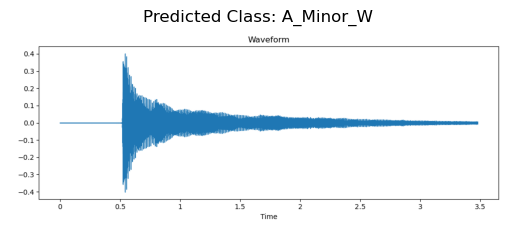

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


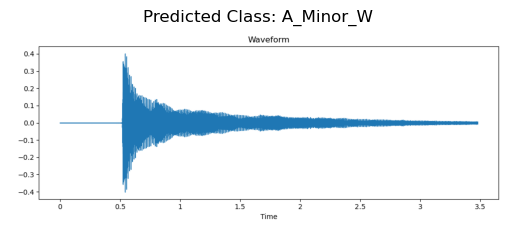

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


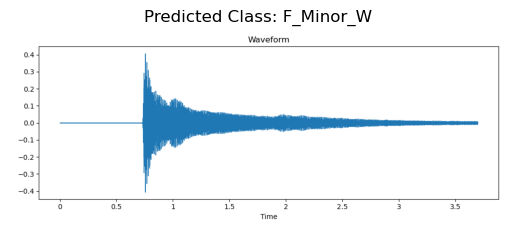

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


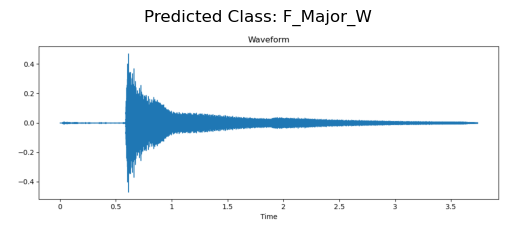

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


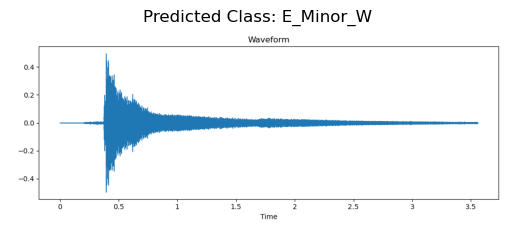

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


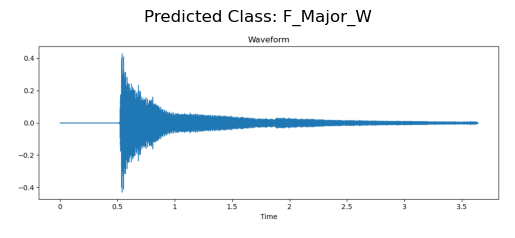

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


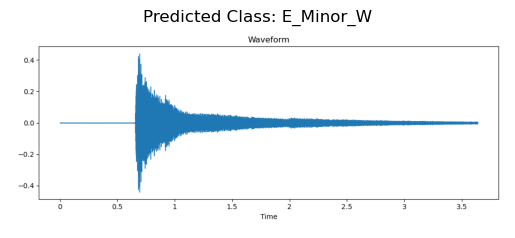

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


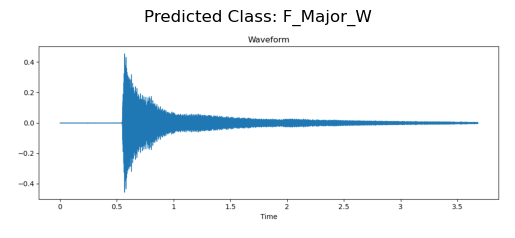

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


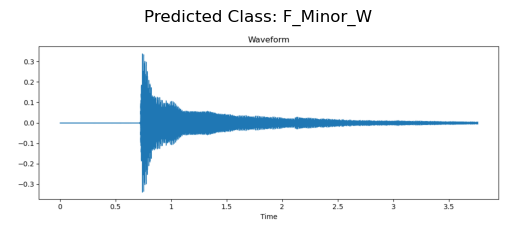

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


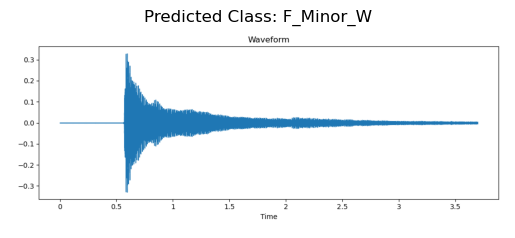

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


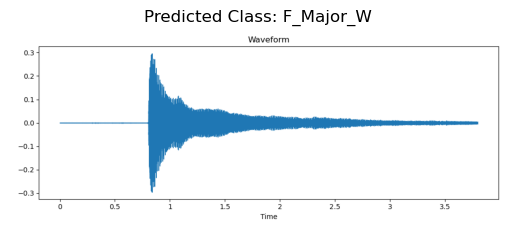

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


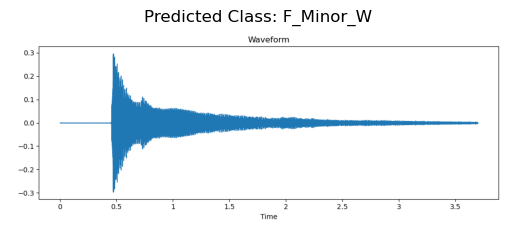

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


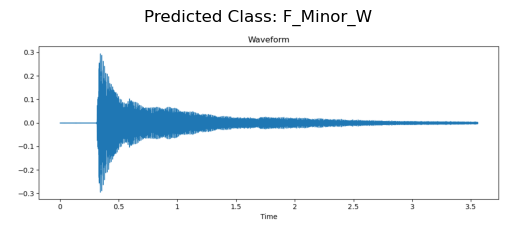

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


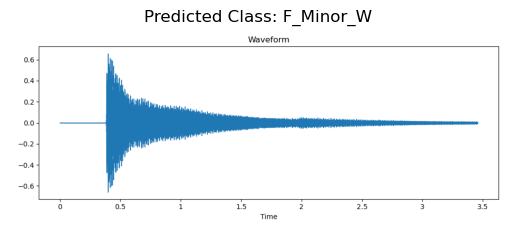

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


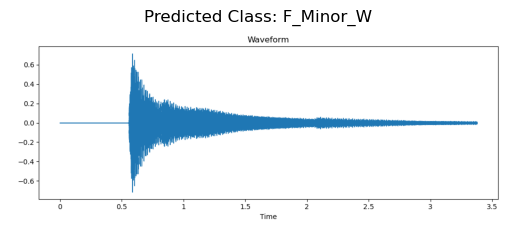

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


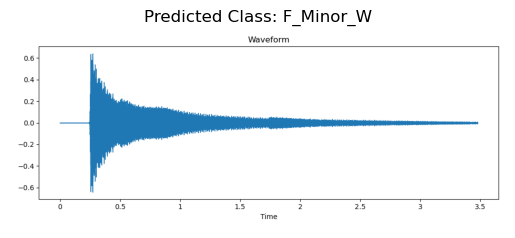

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


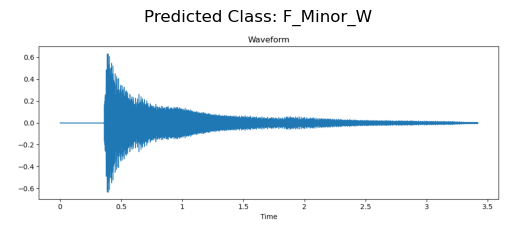

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


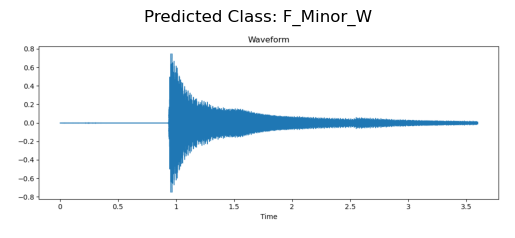

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


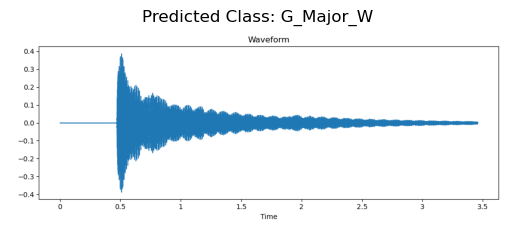

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


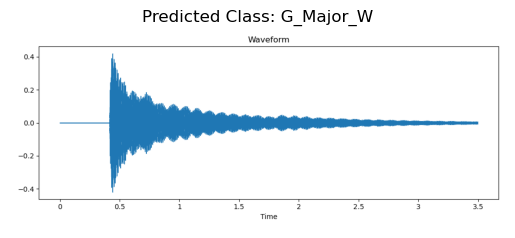

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


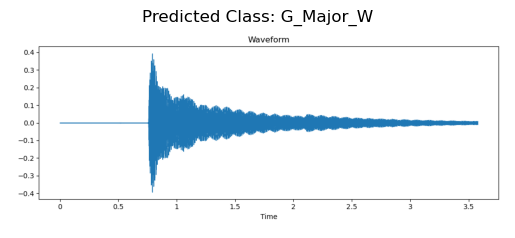

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


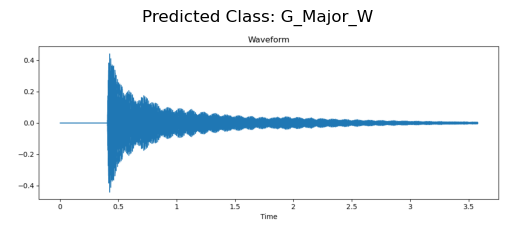

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


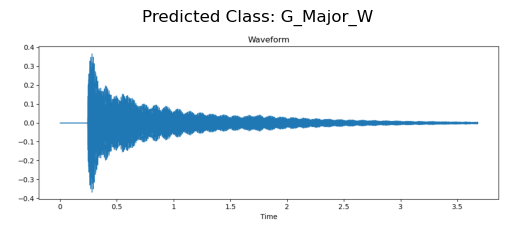

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


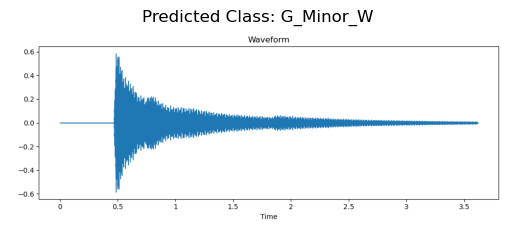

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


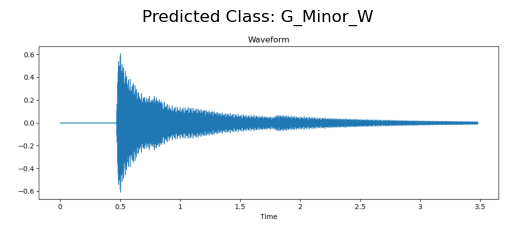

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


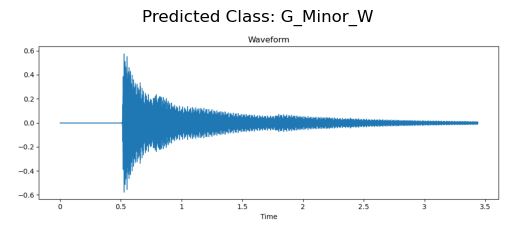

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


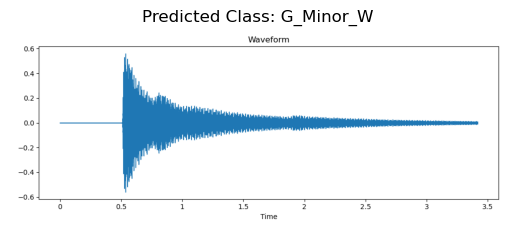

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


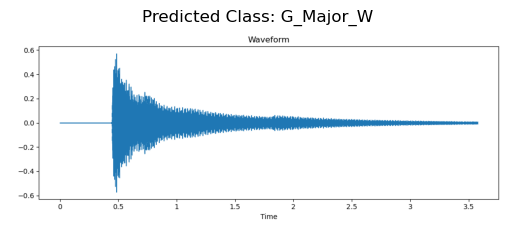

In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/inceptionV3_Upd.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(validation_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to display the image with the predicted class name
def display_image_with_prediction(img_path):
    predicted_class_name = classify_image(img_path)
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

# Function to classify all images in a folder
def classify_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            display_image_with_prediction(img_path)

# Example usage
folder_path = 'E:/Music Chord/Data70_30_ (75)/Test'  # Replace with your folder path
classify_images_in_folder(folder_path)

Piano Dataset of sub_classes Confusion Matrix and Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13

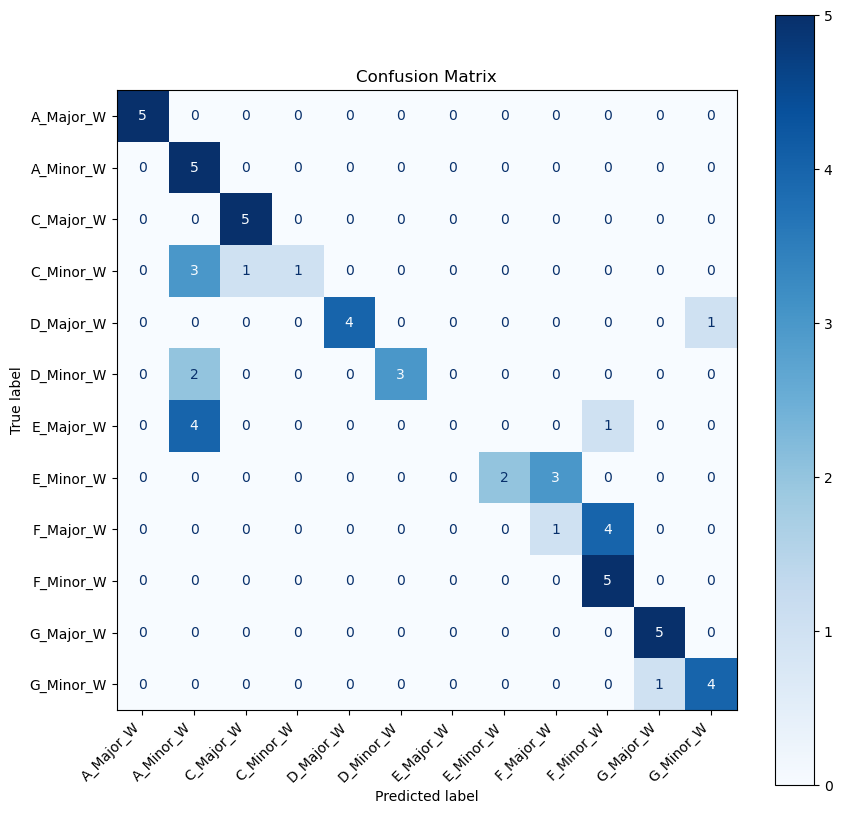

Accuracy: 66.67%


In [49]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/inceptionV3_Upd.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(validation_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:/Music Chord/Data70_30_ (75)/Test2'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Guiter Dataset with sub_Folders , Confiction Matrix and accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

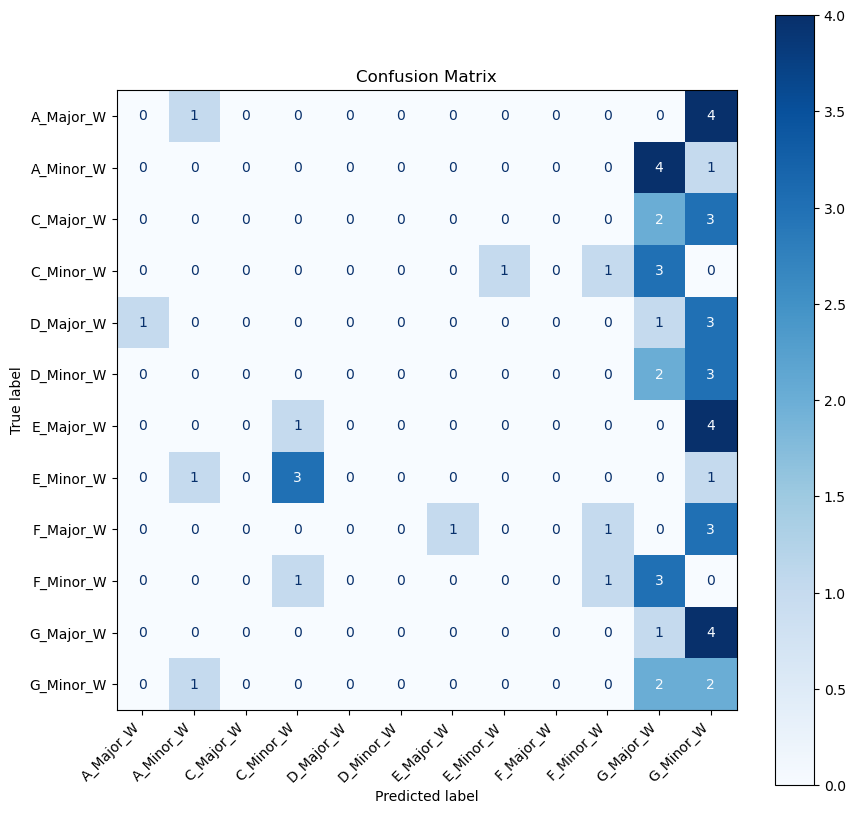

Accuracy: 6.67%


In [50]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/inceptionV3_Upd.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(validation_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:\Music Chord\Giter_dataset(5)'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


NEW GUITER

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image: E:/Music Chord/New\A_Major_W\A_major_W (1).png
Specified Class Label (from folder): A_Major_W, Predicted: F_Minor_W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Image: E:/Music Chord/New\A_Major_W\A_major_W (2).png
Specified Class Label (from folder): A_Major_W, Predicted: F_Minor_W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Image: E:/Music Chord/New\A_Major_W\A_major_W (3).png
Specified Class Label (from folder): A_Major_W, Predicted: E_Major_W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Image: E:/Music Chord/New\A_Major_W\A_major_W (4).png
Specified Class Label (from folder): A_Major_W, Predicted: G_Major_W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Image: E:/Music Chord/New\A_Major_W\A_major_W (5).png
Specified Class Label (from folder): A_Major_W, Predicted: F_Minor_W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Image: E:/Music Chord/New\A_Minor_W\A_minor_W (1).png
Specified Class Label (from folder): A_Minor_W, Predicted: F_Minor_W
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103

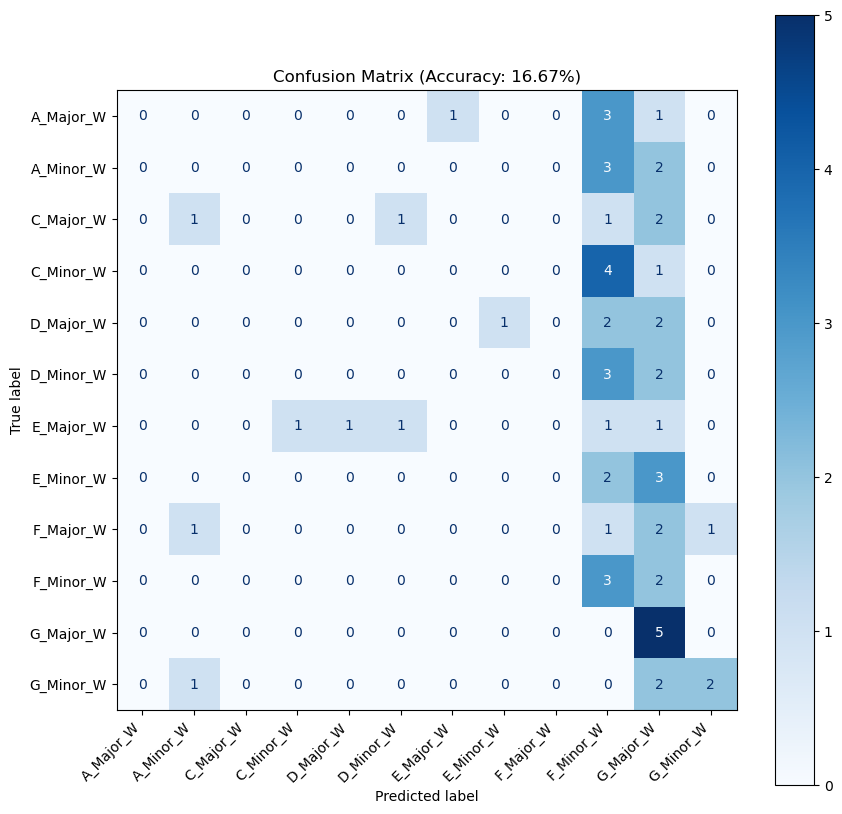

Accuracy: 16.67%


In [51]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/inceptionV3_Upd.h5')

# Define the specific class labels you want to use
class_labels = [
    'A_Major_W', 'A_Minor_W', 'C_Major_W', 'C_Minor_W', 
    'D_Major_W', 'D_Minor_W', 'E_Major_W', 'E_Minor_W', 
    'F_Major_W', 'F_Minor_W', 'G_Major_W', 'G_Minor_W'
]

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []
    match_count = 0
    total_count = 0

    # Iterate through each class folder
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        
        # Ensure it's a directory
        if os.path.isdir(class_folder) and class_name in class_labels:
            # Iterate through images in the class folder
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    # Extract the class label from the folder name
                    specified_class_label = class_name

                    # Classify the image
                    predicted_class_name = classify_image(img_path)

                    true_labels.append(specified_class_label)
                    predicted_labels.append(predicted_class_name)

                    # Logging for debug purposes
                    print(f'Image: {img_path}')
                    print(f'Specified Class Label (from folder): {specified_class_label}, Predicted: {predicted_class_name}')

                    if predicted_class_name == specified_class_label:
                        match_count += 1
                    total_count += 1

    if total_count == 0:
        raise ValueError("No valid images were found in the specified folder. Please check the class labels and image names.")

    # Generate confusion matrix with filtered labels
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = match_count / total_count * 100  # Compute strict accuracy based on exact matches

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:/Music Chord/New'  # Replace with your top-level folder path containing subfolders
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Dataset of both Guiter And Piano

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

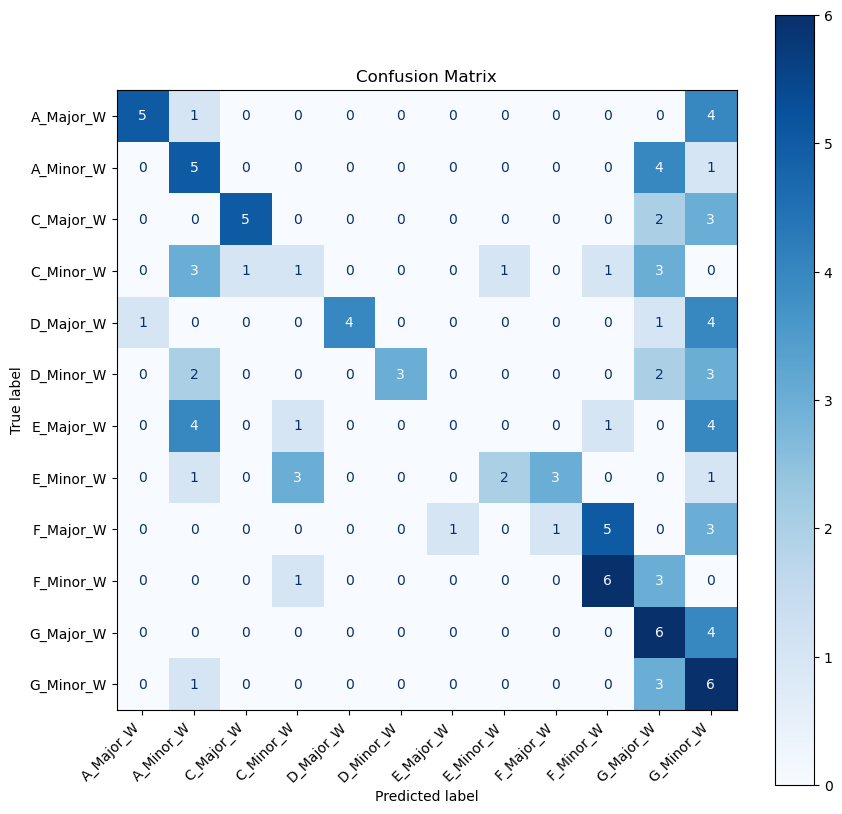

Accuracy: 36.67%


In [52]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model
model = tf.keras.models.load_model('E:/Music Chord/Models/inceptionV3_Upd.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = list(validation_set.class_indices.keys())

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to generate confusion matrix and display it along with accuracy
def display_confusion_matrix_and_accuracy(folder_path):
    true_labels = []
    predicted_labels = []

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.endswith(('png', 'jpg', 'jpeg')):
                    predicted_class_name = classify_image(img_path)
                    true_labels.append(class_name)
                    predicted_labels.append(predicted_class_name)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    accuracy = np.trace(cm) / np.sum(cm) * 100  # Compute accuracy

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    plt.yticks(rotation=0)  # Ensure y-axis labels are readable
    plt.title(f'Confusion Matrix')  # Display accuracy in the title
    plt.show()

    return accuracy

# Example usage
test_folder_path = 'E:\Music Chord\Both'  # Replace with your folder path
accuracy = display_confusion_matrix_and_accuracy(test_folder_path)
print(f'Accuracy: {accuracy:.2f}%')


Images of all classes in single folder -Piano

Files in directory 'E:/Music Chord/Data70_30_ (75)/Test3': ['A_Major_W.png', 'A_Minor_W.png', 'C_Major_W.png', 'C_Minor_W.png', 'D_Major_W.png', 'D_Minor_W.png', 'E_Major_W.png', 'E_Minor_W.png', 'F_Major_W.png', 'F_Minor_W.png', 'G_Major_W.png', 'G_Minor_W.png']
Number of test images: 12
Number of test labels: 12
Test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
True labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Predicted labels: [ 0  1  2  3  4  4  4  7  9  9 10 11]
Accuracy: 75.00%


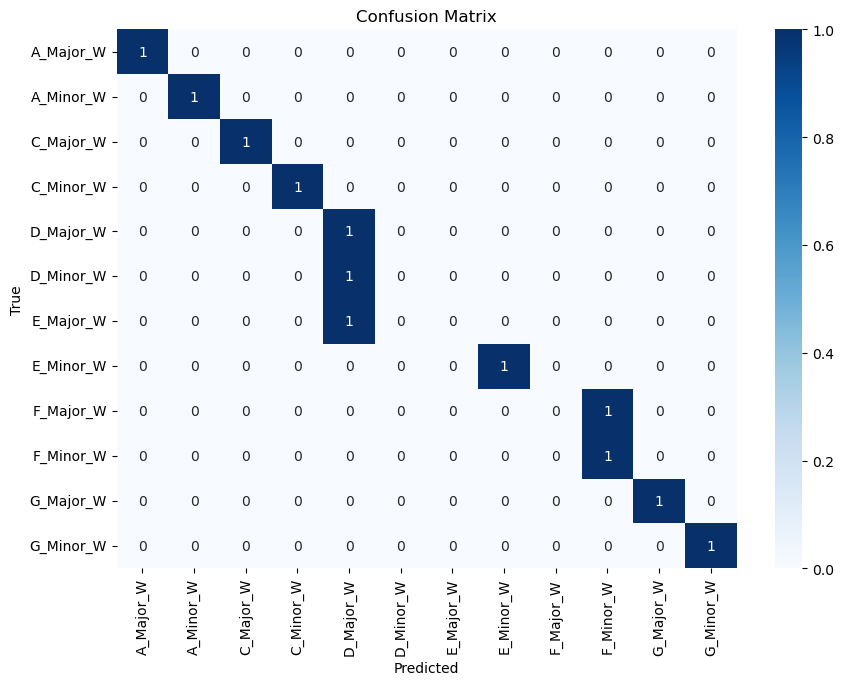

              precision    recall  f1-score   support

   A_Major_W       1.00      1.00      1.00         1
   A_Minor_W       1.00      1.00      1.00         1
   C_Major_W       1.00      1.00      1.00         1
   C_Minor_W       1.00      1.00      1.00         1
   D_Major_W       0.33      1.00      0.50         1
   D_Minor_W       0.00      0.00      0.00         1
   E_Major_W       0.00      0.00      0.00         1
   E_Minor_W       1.00      1.00      1.00         1
   F_Major_W       0.00      0.00      0.00         1
   F_Minor_W       0.50      1.00      0.67         1
   G_Major_W       1.00      1.00      1.00         1
   G_Minor_W       1.00      1.00      1.00         1

    accuracy                           0.75        12
   macro avg       0.65      0.75      0.68        12
weighted avg       0.65      0.75      0.68        12



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test3'
model_path = 'E:/Music Chord/Models/inceptionV3_Upd.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Load and preprocess test images
test_images = []
test_labels = []  # This should be a list of true labels for each test image
class_labels = ['A_Major_W', 'A_Minor_W', 'C_Major_W', 'C_Minor_W', 'D_Major_W', 'D_Minor_W',
                'E_Major_W', 'E_Minor_W', 'F_Major_W', 'F_Minor_W', 'G_Major_W', 'G_Minor_W']  # Define your classes here

# Print debug information about the files in the test directory
print(f"Files in directory '{test_dir}': {os.listdir(test_dir)}")

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)
            test_images.append(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename

            # Check if the entire filename (without extension) matches a class label
            if label_name in class_labels:
                test_labels.append(class_labels.index(label_name))
            else:
                print(f"Warning: '{label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels

# Debug: Print out the true labels and predicted labels
print(f'True labels: {y_true}')
print(f'Predicted labels: {y_pred}')

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


60 Images of all classes in single folder -Piano

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Accuracy: 63.33%


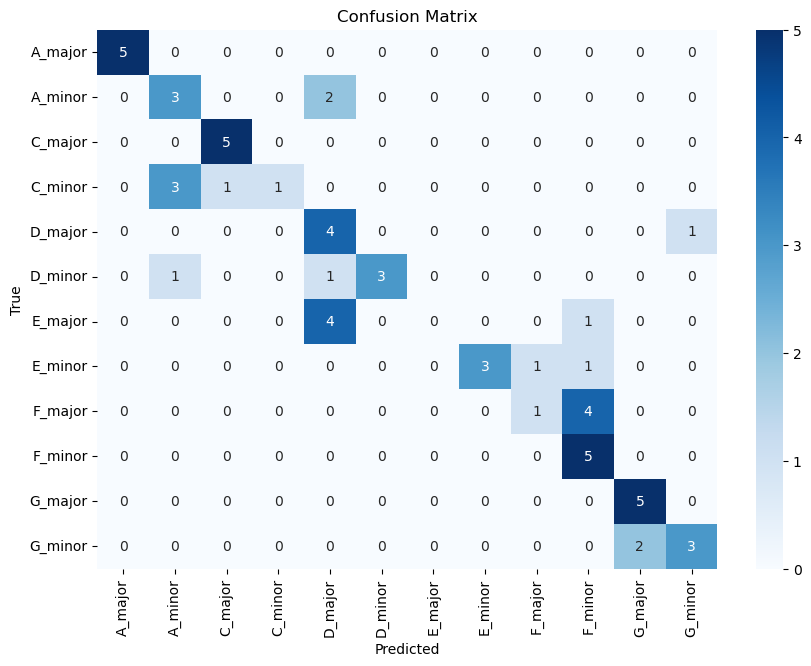

              precision    recall  f1-score   support

     A_major       1.00      1.00      1.00         5
     A_minor       0.43      0.60      0.50         5
     C_major       0.83      1.00      0.91         5
     C_minor       1.00      0.20      0.33         5
     D_major       0.36      0.80      0.50         5
     D_minor       1.00      0.60      0.75         5
     E_major       0.00      0.00      0.00         5
     E_minor       1.00      0.60      0.75         5
     F_major       0.50      0.20      0.29         5
     F_minor       0.45      1.00      0.62         5
     G_major       0.71      1.00      0.83         5
     G_minor       0.75      0.60      0.67         5

    accuracy                           0.63        60
   macro avg       0.67      0.63      0.60        60
weighted avg       0.67      0.63      0.60        60

Misclassified sample: True label = A_minor, Predicted label = D_major
Misclassified sample: True label = A_minor, Predicted label = D

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test'
model_path = 'E:/Music Chord/Models/inceptionV3_Upd.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_major', 'A_minor', 'C_major', 'C_minor', 'D_major', 'D_minor',
                'E_major', 'E_minor', 'F_major', 'F_minor', 'G_major', 'G_minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


60 images of Guiter in single folder 

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/stepWARNING:tensorflow:6 out of the last 125 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024BF74EC4A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Accuracy: 11.67%


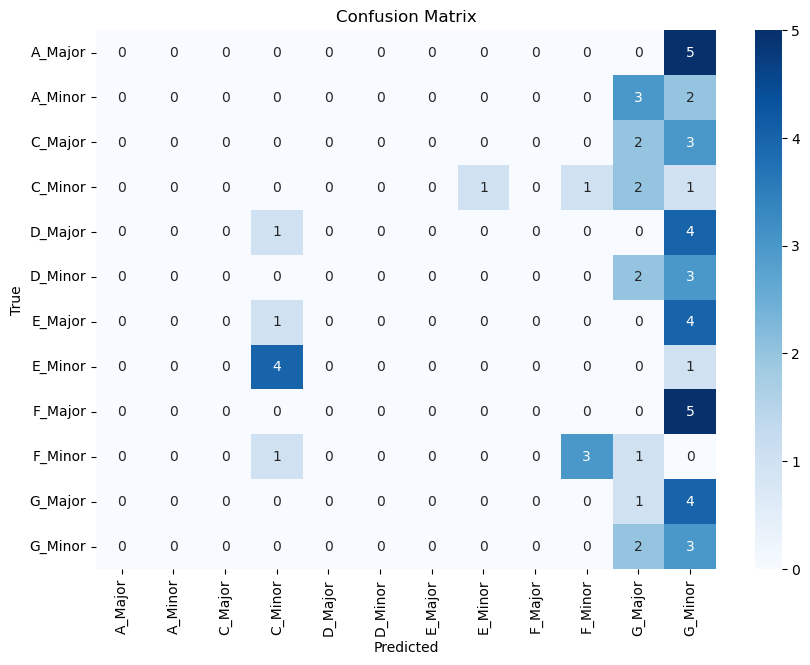

              precision    recall  f1-score   support

     A_Major       0.00      0.00      0.00         5
     A_Minor       0.00      0.00      0.00         5
     C_Major       0.00      0.00      0.00         5
     C_Minor       0.00      0.00      0.00         5
     D_Major       0.00      0.00      0.00         5
     D_Minor       0.00      0.00      0.00         5
     E_Major       0.00      0.00      0.00         5
     E_Minor       0.00      0.00      0.00         5
     F_Major       0.00      0.00      0.00         5
     F_Minor       0.75      0.60      0.67         5
     G_Major       0.08      0.20      0.11         5
     G_Minor       0.09      0.60      0.15         5

    accuracy                           0.12        60
   macro avg       0.08      0.12      0.08        60
weighted avg       0.08      0.12      0.08        60

Misclassified sample: True label = A_Major, Predicted label = G_Minor
Misclassified sample: True label = A_Major, Predicted label = G

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test4'
model_path = 'E:/Music Chord/Models/inceptionV3_Upd.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_Major', 'A_Minor', 'C_Major', 'C_Minor', 'D_Major', 'D_Minor',
                'E_Major', 'E_Minor', 'F_Major', 'F_Minor', 'G_Major', 'G_Minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


30-30 Images of Panio and Guiter

Number of test images: 60
Number of test labels: 60
Test labels: [ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11]
Unique test labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
Accuracy: 46.67%


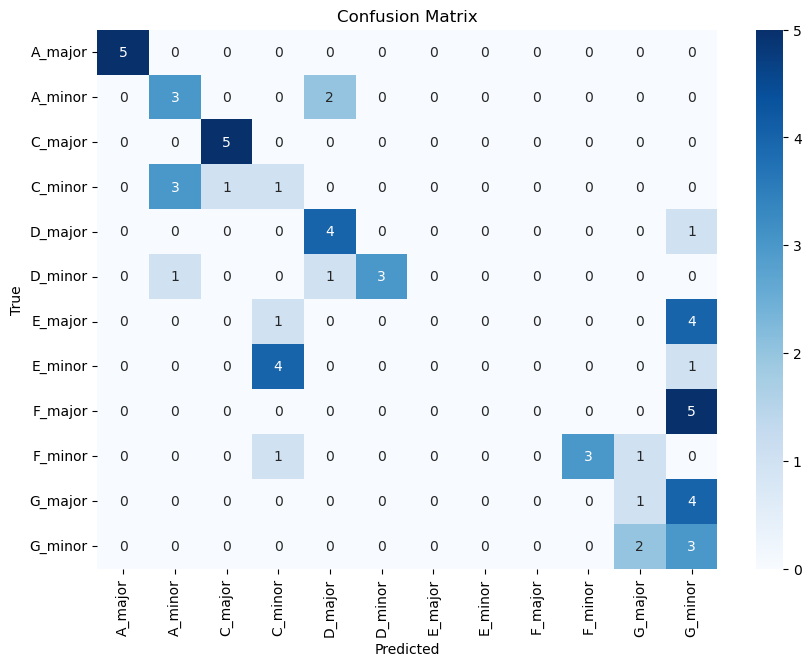

              precision    recall  f1-score   support

     A_major       1.00      1.00      1.00         5
     A_minor       0.43      0.60      0.50         5
     C_major       0.83      1.00      0.91         5
     C_minor       0.14      0.20      0.17         5
     D_major       0.57      0.80      0.67         5
     D_minor       1.00      0.60      0.75         5
     E_major       0.00      0.00      0.00         5
     E_minor       0.00      0.00      0.00         5
     F_major       0.00      0.00      0.00         5
     F_minor       1.00      0.60      0.75         5
     G_major       0.25      0.20      0.22         5
     G_minor       0.17      0.60      0.26         5

    accuracy                           0.47        60
   macro avg       0.45      0.47      0.44        60
weighted avg       0.45      0.47      0.44        60

Misclassified sample: True label = A_minor, Predicted label = D_major
Misclassified sample: True label = A_minor, Predicted label = D

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set up paths and parameters
test_dir = 'E:/Music Chord/Data70_30_ (75)/Test5'
model_path = 'E:/Music Chord/Models/inceptionV3_Upd.h5'
image_size = (224, 224)  # Adjust to 300x300 based on the trained model

# Load your trained model
model = load_model(model_path)

# Define class labels
class_labels = ['A_major', 'A_minor', 'C_major', 'C_minor', 'D_major', 'D_minor',
                'E_major', 'E_minor', 'F_major', 'F_minor', 'G_major', 'G_minor']

# Function to clean up label names
def clean_label(label):
    # Remove numbers and special characters after underscore and parentheses
    clean_label = re.sub(r'_\s*\(\d+\)', '', label)
    return clean_label

# Load and preprocess test images
test_images = []
test_labels = []

# Manually load images and their labels
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)

    # Check if the path is a file and is an image
    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img)
            img = preprocess_input(img)

            # Extract the label from the filename by removing the extension
            label_name = os.path.splitext(img_name)[0]  # Extract the class part of the filename
            clean_label_name = clean_label(label_name)  # Clean the label name

            # Check if the cleaned label is in the defined class labels
            if clean_label_name in class_labels:
                test_images.append(img)
                test_labels.append(class_labels.index(clean_label_name))
            else:
                print(f"Warning: '{clean_label_name}' extracted from '{img_name}' is not in class_labels")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")
    else:
        print(f"Skipping non-image file {img_path}")

# Convert lists to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Ensure there are test images before proceeding
if len(test_images) == 0 or len(test_labels) == 0:
    raise ValueError("No valid test images or labels found. Please check the test directory and file formats.")

# Debug prints
print(f'Number of test images: {len(test_images)}')
print(f'Number of test labels: {len(test_labels)}')
print(f'Test labels: {test_labels}')
print(f'Unique test labels: {np.unique(test_labels)}')

# Verify that all unique test labels are within the class_labels index range
if not all(label in range(len(class_labels)) for label in test_labels):
    raise ValueError("Test labels contain invalid class indices. Please check the label extraction process.")

# Predict the classes of test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, y_pred, target_names=class_labels)
print(report)

# Additional debug: print misclassified samples
misclassified_indices = np.where(test_labels != y_pred)[0]
for idx in misclassified_indices:
    print(f'Misclassified sample: True label = {class_labels[test_labels[idx]]}, Predicted label = {class_labels[y_pred[idx]]}')


Single image predection - Piano


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Found 60 images belonging to 12 classes.
Predicted class: A_Major_W
True class label: A_Major_W
Is the prediction correct? Yes
Accuracy of the prediction: 100.00%


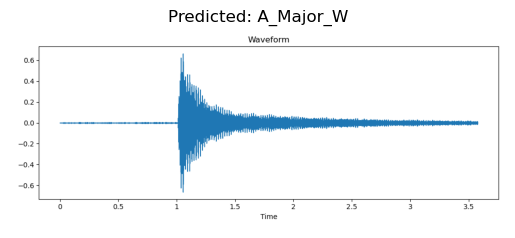

In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved model
model = tf.keras.models.load_model('E:/Music Chord/Models/vgg19.h5')

# Path to the image you want to test
image_path = 'E:/Music Chord/Data70_30_ (75)/Test3/A_Major_W.png'

# Preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale image (same as training)
    return img_array

# Extract true class label from the image filename
def extract_true_class_label(image_path):
    # Assuming the image filename contains the class label
    return os.path.splitext(os.path.basename(image_path))[0]

# Preprocess the input image
image = preprocess_image(image_path)

# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Load the test dataset to get the class labels
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    'E:/Music Chord/Data70_30_ (75)/Test2',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
class_labels = list(test_generator.class_indices.keys())

# Print the predicted class
predicted_class_label = class_labels[predicted_class]
print(f'Predicted class: {predicted_class_label}')

# Get the true class label
true_class_label = extract_true_class_label(image_path)
print(f'True class label: {true_class_label}')

# Check if the prediction is correct
is_correct = (predicted_class_label.lower() == true_class_label.lower())
print(f'Is the prediction correct? {"Yes" if is_correct else "No"}')

# Print accuracy
accuracy = 100.0 if is_correct else 0.0
print(f'Accuracy of the prediction: {accuracy:.2f}%')

# Optional: Display the image
img = load_img(image_path)
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

# # Debug: Print the directory structure and image path
# print(f'Directory containing the image: {os.path.dirname(image_path)}')
# print(f'Base name of the directory: {os.path.basename(os.path.dirname(image_path))}')
# print(f'Image filename: {os.path.basename(image_path)}')
# print(f'Extracted true class label: {true_class_label}')